In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import LabelEncoder



# === 1. 檔案合併與 train/test 分割 ===
lab_data = pd.read_csv('csv_data/lab_data 20240509-20240801.csv')
input_v4 = pd.read_csv('csv_data/input_v5.csv')
test = pd.read_csv('csv_data/test.csv')

lab_data['CNO'] = lab_data['CNO'].astype(str)
input_v4['CNO'] = input_v4['CNO'].astype(str)
lab_data['TIME'] = pd.to_datetime(lab_data['TIME'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')
input_v4['TIME'] = pd.to_datetime(input_v4['TIME'], errors='coerce').dt.strftime('%Y-%m-%d %H:%M:%S')

file_map = lab_data[['CNO', 'TIME', 'file_name']].drop_duplicates()
input_v4_with_file = input_v4.merge(file_map, on=['CNO', 'TIME'], how='left')

test_file_names = test['file_name'].astype(str).unique()
input_v4_with_file['file_name'] = input_v4_with_file['file_name'].astype(str).str.strip()
test_file_names = [fn.strip() for fn in test_file_names]

test_idx = input_v4_with_file['file_name'].isin(test_file_names)
X_test = input_v4_with_file[test_idx].copy()
X_train = input_v4_with_file[~test_idx].copy()

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (4186, 23)
Test shape: (467, 23)



========== day1_all_features ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64

📊 day1_all_features 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.5000 |
| Recall     | 0.1111 |
| F1-score   | 0.1818 |
| Accuracy   | 0.9807 |
| AUC        | 0.8462 |


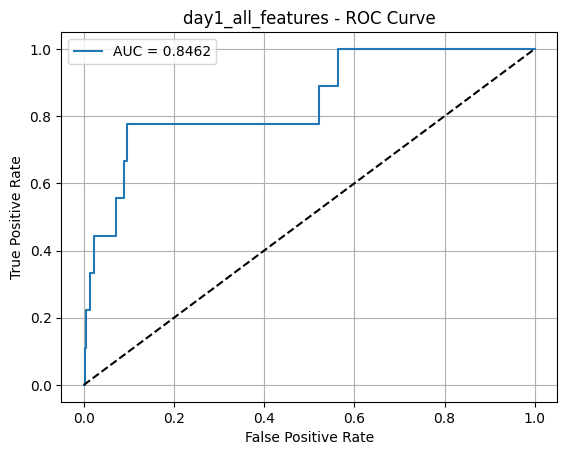

📌 day1_three_features：Top 3 特徵 => ['PLT_2', 'RDW_2', 'MCHC..g.dL.']

========== day1_three_features ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64

📊 day1_three_features 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.0000 |
| Recall     | 0.0000 |
| F1-score   | 0.0000 |
| Accuracy   | 0.9786 |
| AUC        | 0.8268 |


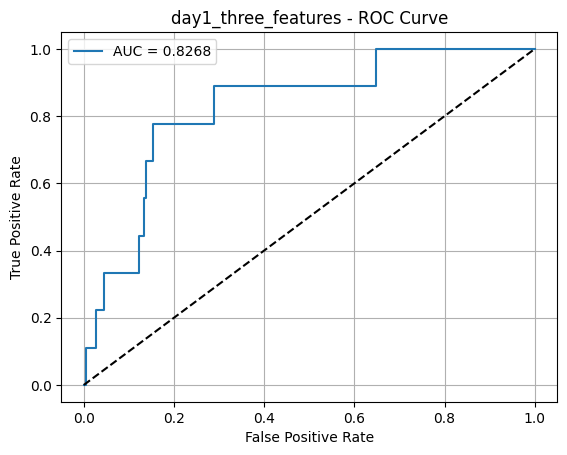


========== day3_all_features ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64

📊 day3_all_features 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6250 |
| Recall     | 0.1786 |
| F1-score   | 0.2778 |
| Accuracy   | 0.9443 |
| AUC        | 0.8470 |


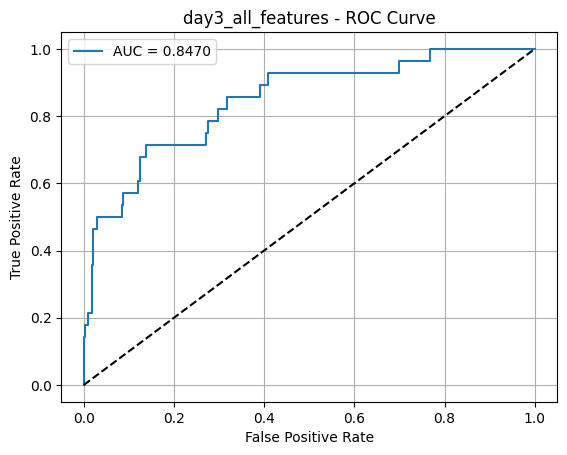

📌 day3_three_features：Top 3 特徵 => ['PLT_2', 'WBC_2', 'GLU_2']

========== day3_three_features ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64

📊 day3_three_features 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 1.0000 |
| Recall     | 0.0357 |
| F1-score   | 0.0690 |
| Accuracy   | 0.9422 |
| AUC        | 0.7602 |


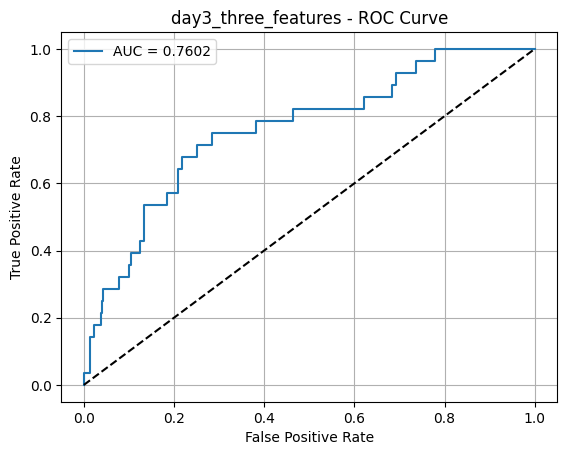


========== day5_all_features ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64

📊 day5_all_features 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6875 |
| Recall     | 0.2821 |
| F1-score   | 0.4000 |
| Accuracy   | 0.9293 |
| AUC        | 0.8977 |


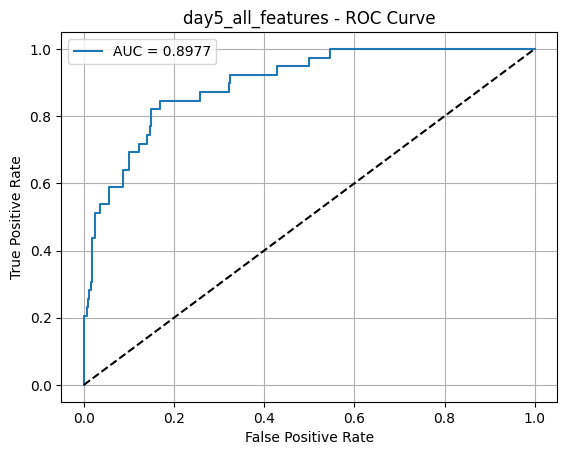

📌 day5_three_features：Top 3 特徵 => ['PLT_2', 'CRP', 'WBC_2']

========== day5_three_features ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64

📊 day5_three_features 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.7143 |
| Recall     | 0.1282 |
| F1-score   | 0.2174 |
| Accuracy   | 0.9229 |
| AUC        | 0.8021 |


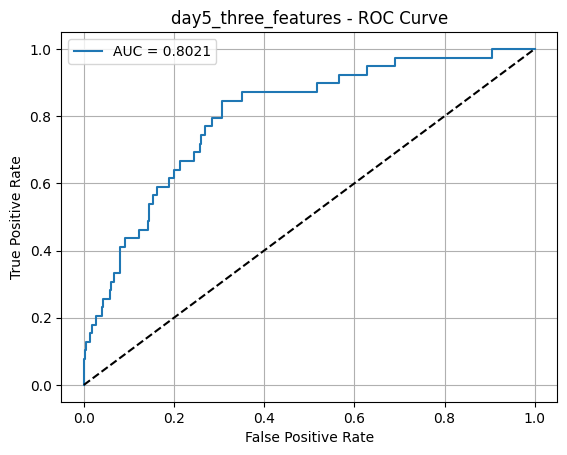

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap

df = input_v4_with_file

# ========== 2. 產生標籤欄位 ==========
# 建立標籤
for df in [X_train, X_test]:
    df['death_within_1_day'] = ((df['event[all-cause mortality]'] == 1) & (df['time[all-cause mortality]'] <= 1)).astype(int)
    df['death_within_3_days'] = ((df['event[all-cause mortality]'] == 1) & (df['time[all-cause mortality]'] <= 3)).astype(int)
    df['death_within_5_days'] = ((df['event[all-cause mortality]'] == 1) & (df['time[all-cause mortality]'] <= 5)).astype(int)

# ========== 3. 特徵欄位處理 ==========
drop_cols = ['HOS', 'CNO', 'TIME', 'TYPE', 'ORGANISM', 'CLASS_1',
             'time[all-cause mortality]', 'event[all-cause mortality]', 'days_diff','file_name']
target_labels = ['death_within_1_day', 'death_within_3_days', 'death_within_5_days']
feature_cols = [col for col in df.columns if col not in drop_cols + target_labels]

for col in feature_cols:
    if X_train[col].dtype == 'object':
        le = LabelEncoder()
        # 合併 train/test 保證一致編碼
        all_values = pd.concat([X_train[col], X_test[col]]).astype(str)
        le.fit(all_values)
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))

# 類別型欄位轉數字
for df in [X_train, X_test]:
    for col in X_train[feature_cols].select_dtypes(include='object').columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    # df[feature_cols] = df[feature_cols].fillna(df[feature_cols].median())
    # 只對數值型欄位補中位數
    num_cols = df[feature_cols].select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    # 類別型欄位補 'missing'
    cat_cols = df[feature_cols].select_dtypes(include=['object']).columns
    df[cat_cols] = df[cat_cols].fillna('missing')
df_model = df.copy()

# ========== 4. 訓練與評估（無 plot） ==========
def train_and_evaluate(df, feature_cols, label_col, title=''):
    y_train = X_train[label_col]
    y_test = X_test[label_col]

    print(f"\n========== {title} ==========")
    print("原始類別分布：\n", y_test.value_counts())

    model = XGBClassifier(eval_metric='logloss', verbosity=0)
    model.fit(X_train[feature_cols], y_train)

    y_pred = model.predict(X_test[feature_cols])
    y_proba = model.predict_proba(X_test[feature_cols])[:, 1]

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n📊 {title} 評估結果:")
    print(f"| 指標       | 數值   |")
    print(f"|------------|--------|")
    print(f"| Precision  | {precision:.4f} |")
    print(f"| Recall     | {recall:.4f} |")
    print(f"| F1-score   | {f1:.4f} |")
    print(f"| Accuracy   | {accuracy:.4f} |")
    print(f"| AUC        | {auc:.4f} |")
    # ROC 曲線
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'{title} - ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # SHAP 重要性
    explainer = shap.Explainer(model, X_test[feature_cols])
    shap_values = explainer(X_test[feature_cols])

    return model, shap_values, feature_cols

# ========== 5. 執行任務 ==========
order = [(1, 'day1_all_features', 'day1_three_features'),
         (3, 'day3_all_features', 'day3_three_features'),
         (5, 'day5_all_features', 'day5_three_features')]

for day, full_title, top3_title in order:
    label = f'death_within_{day}_day' if day == 1 else f'death_within_{day}_days'

    # (a) 使用全部特徵
    model_full, shap_vals, used_features = train_and_evaluate(df_model, feature_cols, label, title=full_title)

    # (b) 使用最重要的前三個特徵
    shap_mean = np.abs(shap_vals.values).mean(axis=0)
    top3_idx = np.argsort(shap_mean)[-3:][::-1]
    top3_feats = [used_features[i] for i in top3_idx]
    print(f"📌 {top3_title}：Top 3 特徵 => {top3_feats}")

    model_top3, _, _ = train_and_evaluate(df_model, top3_feats, label, title=top3_title)


4119
67

========== day1_all_features_2x ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(134)}
SMOTE 後類別分布：
 death_within_1_day
0    4119
1     134
Name: count, dtype: int64

📊 day1_all_features_2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.3333 |
| Recall     | 0.1111 |
| F1-score   | 0.1667 |
| Accuracy   | 0.9786 |
| AUC        | 0.8666 |


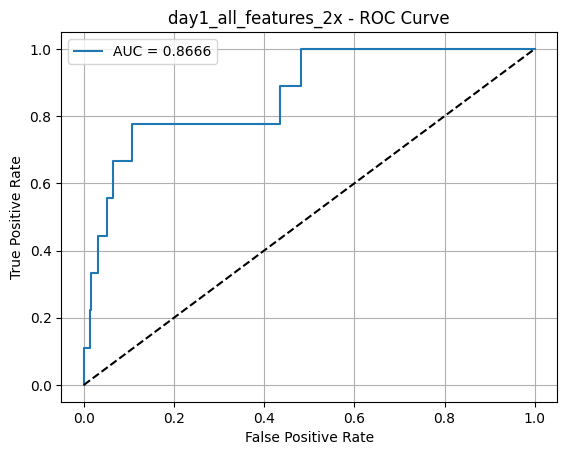

📌 day1_three_features_2x：Top 3 特徵 => ['RDW_2', 'PLT_2', 'MCV..fL.']

========== day1_all_features_3x ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(201)}
SMOTE 後類別分布：
 death_within_1_day
0    4119
1     201
Name: count, dtype: int64

📊 day1_all_features_3x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.4000 |
| Recall     | 0.2222 |
| F1-score   | 0.2857 |
| Accuracy   | 0.9786 |
| AUC        | 0.8467 |


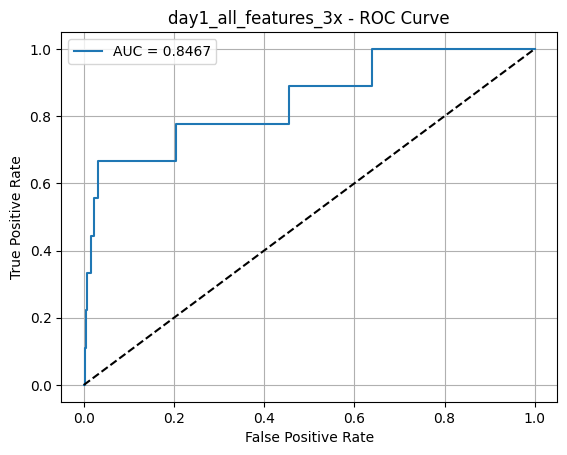

📌 day1_three_features_3x：Top 3 特徵 => ['PLT_2', 'MCV..fL.', 'MCHC..g.dL.']
4023
163

========== day3_all_features_2x ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(326)}
SMOTE 後類別分布：
 death_within_3_days
0    4023
1     326
Name: count, dtype: int64

📊 day3_all_features_2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.7000 |
| Recall     | 0.2500 |
| F1-score   | 0.3684 |
| Accuracy   | 0.9486 |
| AUC        | 0.8249 |


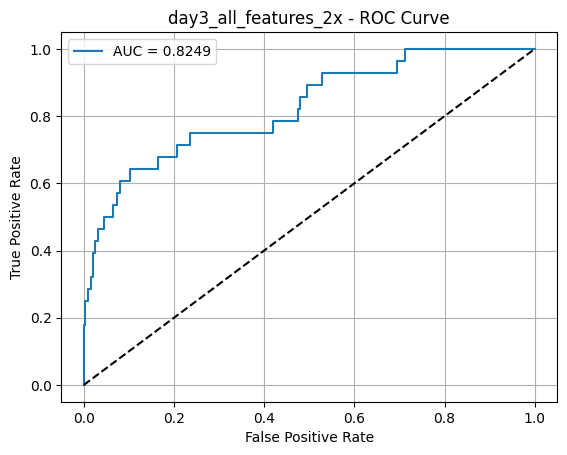

📌 day3_three_features_2x：Top 3 特徵 => ['PLT_2', 'RDW_2', 'GLU_2']

========== day3_all_features_3x ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(489)}
SMOTE 後類別分布：
 death_within_3_days
0    4023
1     489
Name: count, dtype: int64

📊 day3_all_features_3x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6923 |
| Recall     | 0.3214 |
| F1-score   | 0.4390 |
| Accuracy   | 0.9507 |
| AUC        | 0.8196 |


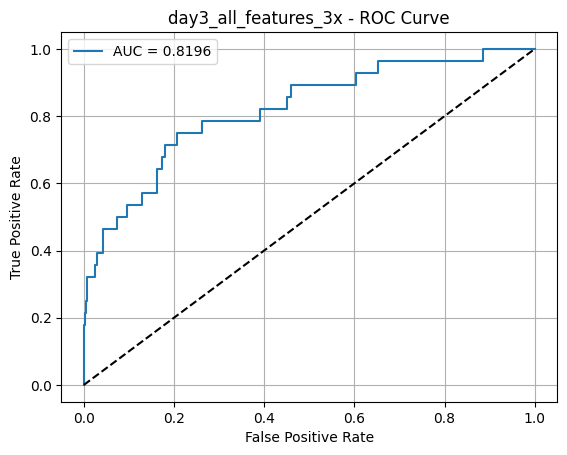

📌 day3_three_features_3x：Top 3 特徵 => ['RDW_2', 'PLT_2', 'CRP']
3924
262

========== day5_all_features_2x ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(524)}
SMOTE 後類別分布：
 death_within_5_days
0    3924
1     524
Name: count, dtype: int64

📊 day5_all_features_2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.5833 |
| Recall     | 0.3590 |
| F1-score   | 0.4444 |
| Accuracy   | 0.9251 |
| AUC        | 0.8705 |


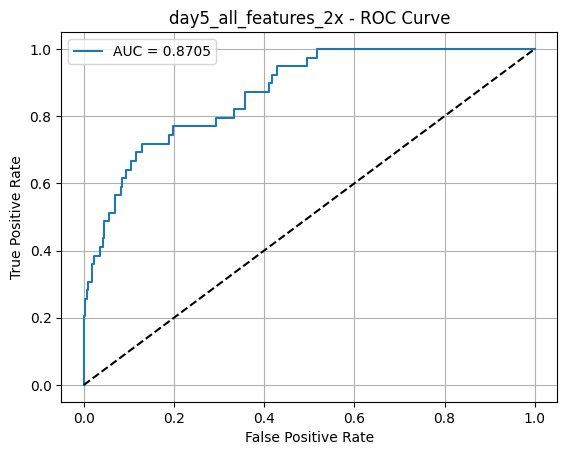

📌 day5_three_features_2x：Top 3 特徵 => ['PLT_2', 'RDW_2', 'CRP']

========== day5_all_features_3x ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(786)}
SMOTE 後類別分布：
 death_within_5_days
0    3924
1     786
Name: count, dtype: int64

📊 day5_all_features_3x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6364 |
| Recall     | 0.3590 |
| F1-score   | 0.4590 |
| Accuracy   | 0.9293 |
| AUC        | 0.8921 |


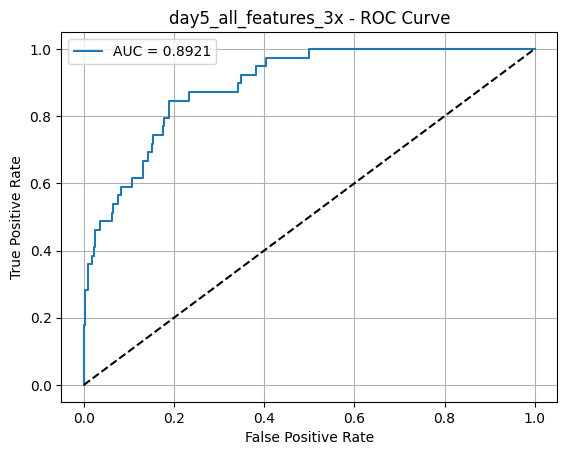

📌 day5_three_features_3x：Top 3 特徵 => ['PLT_2', 'CRP', 'RDW_2']


In [37]:
# def train_and_evaluate_smote_strategy(df, feature_cols, label_col, title='', smote_strategy=None):
def train_and_evaluate_smote_strategy(X_train, X_test, y_train, y_test, feature_cols, title='', smote_strategy=None):
    print(f"\n========== {title} ==========")
    print("原始類別分布：\n", y_test.value_counts())

    X_train_use = X_train.copy()
    y_train_use = y_train.copy()
    if smote_strategy:
        print(f"📌 使用 SMOTE 策略：{smote_strategy}")
        smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
        X_train_use, y_train_use = smote.fit_resample(X_train_use[feature_cols], y_train_use)
        print("SMOTE 後類別分布：\n", pd.Series(y_train_use).value_counts())
    else:
        X_train_use = X_train_use[feature_cols]

    model = XGBClassifier(eval_metric='logloss', verbosity=0)
    model.fit(X_train_use, y_train_use)

    y_pred = model.predict(X_test[feature_cols])
    y_proba = model.predict_proba(X_test[feature_cols])[:, 1]



    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"\n📊 {title} 評估結果:")
    print(f"| 指標       | 數值   |")
    print(f"|------------|--------|")
    print(f"| Precision  | {precision:.4f} |")
    print(f"| Recall     | {recall:.4f} |")
    print(f"| F1-score   | {f1:.4f} |")
    print(f"| Accuracy   | {accuracy:.4f} |")
    print(f"| AUC        | {auc:.4f} |")
    # ROC 曲線
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f'{title} - ROC Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # SHAP 重要性
    explainer = shap.Explainer(model, X_test[feature_cols])
    shap_values = explainer(X_test[feature_cols])

    return model, shap_values, feature_cols

order = [(1, 'day1_all_features', 'day1_three_features'),
         (3, 'day3_all_features', 'day3_three_features'),
         (5, 'day5_all_features', 'day5_three_features')]

for day, full_title, top3_title in order:
    label = f'death_within_{day}_day' if day == 1 else f'death_within_{day}_days'

    # 取得原始 label 分布
    y = X_train[label]
    majority = y.value_counts()[0]
    print(majority)
    minority = y.value_counts()[1]
    print(minority)
    smote_configs = [
        ('2x', {1: min(minority * 2, majority)}),  # 放大兩倍
        ('3x', {1: min(minority * 3, majority)}),       # 放大三倍
        # ('2x_3to2', {1: int(majority * 0.9)}),           # 3:2 (死亡:存活 = 60%)
        # smote_strategy = {1: max(min(minority * 2, majority), minority)}

    ]
    X_train_smote = X_train[feature_cols]
    y_train = X_train[label]
    y_test = X_test[label]

    for tag, smote_strategy in smote_configs:
        title_suffix = f"{full_title}_{tag}"
        model_full, shap_vals, used_features = train_and_evaluate_smote_strategy(
            X_train_smote, X_test, y_train, y_test, feature_cols, title=title_suffix, smote_strategy=smote_strategy
        )

        shap_mean = np.abs(shap_vals.values).mean(axis=0)
        top3_idx = np.argsort(shap_mean)[-3:][::-1]
        top3_feats = [used_features[i] for i in top3_idx]
        print(f"📌 {top3_title}_{tag}：Top 3 特徵 => {top3_feats}")

        # train_and_evaluate(df_model, top3_feats, label, title=f"{top3_title}_{tag}", smote_strategy=smote_strategy)


========== day1 - Base ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64

📊 day1 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.5000 |
| Recall     | 0.1111 |
| F1-score   | 0.1818 |
| Accuracy   | 0.9807 |
| AUC        | 0.8462 |

========== day1 - 2x ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(134)}
SMOTE 後類別分布：
 death_within_1_day
0    4119
1     134
Name: count, dtype: int64

📊 day1 - 2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.3333 |
| Recall     | 0.1111 |
| F1-score   | 0.1667 |
| Accuracy   | 0.9786 |
| AUC        | 0.8666 |

========== day1 - 3x ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(201)}
SMOTE 後類別分布：
 death_within_1_day
0    4119
1     201
Name: count, dtype: int64

📊 day1 - 3x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.4000 |
| Re

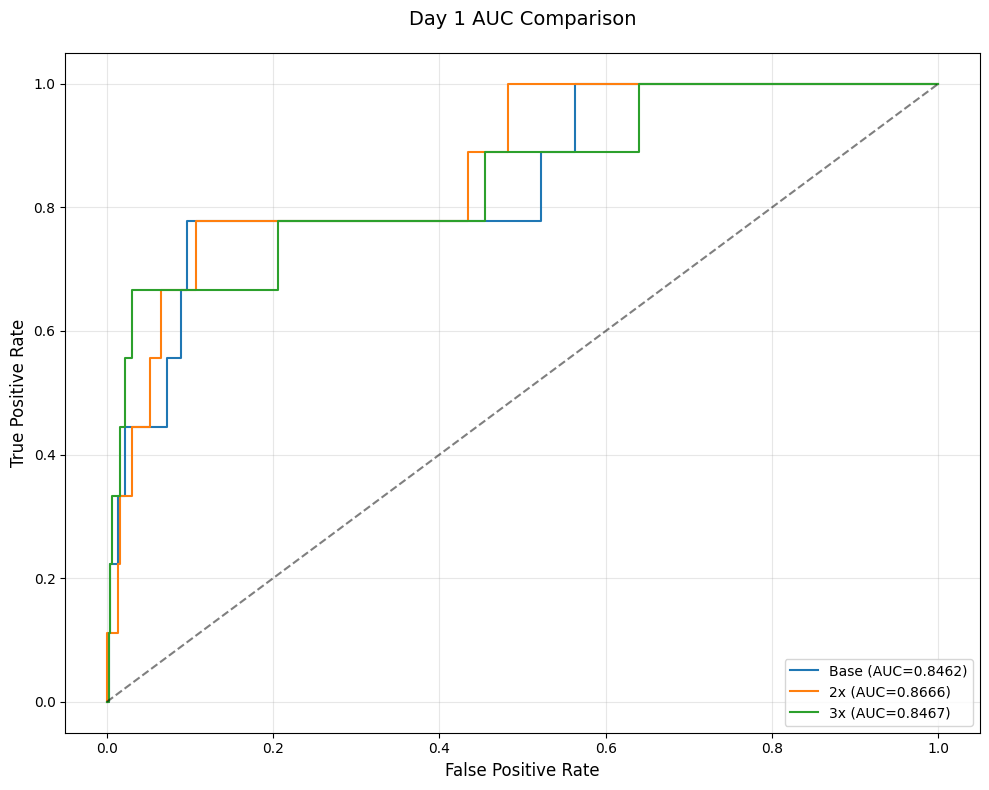

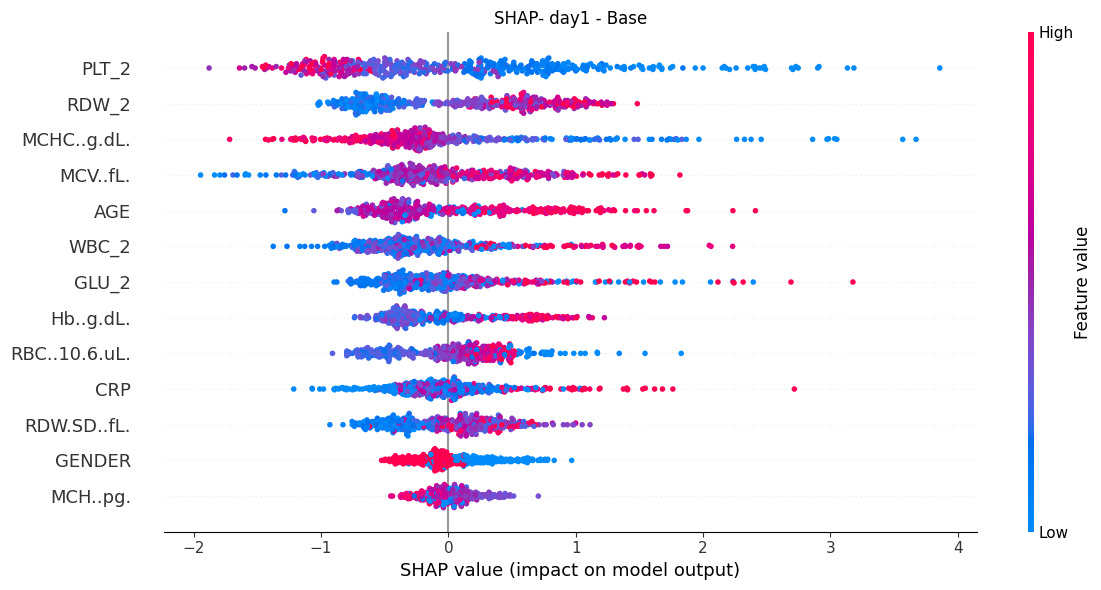

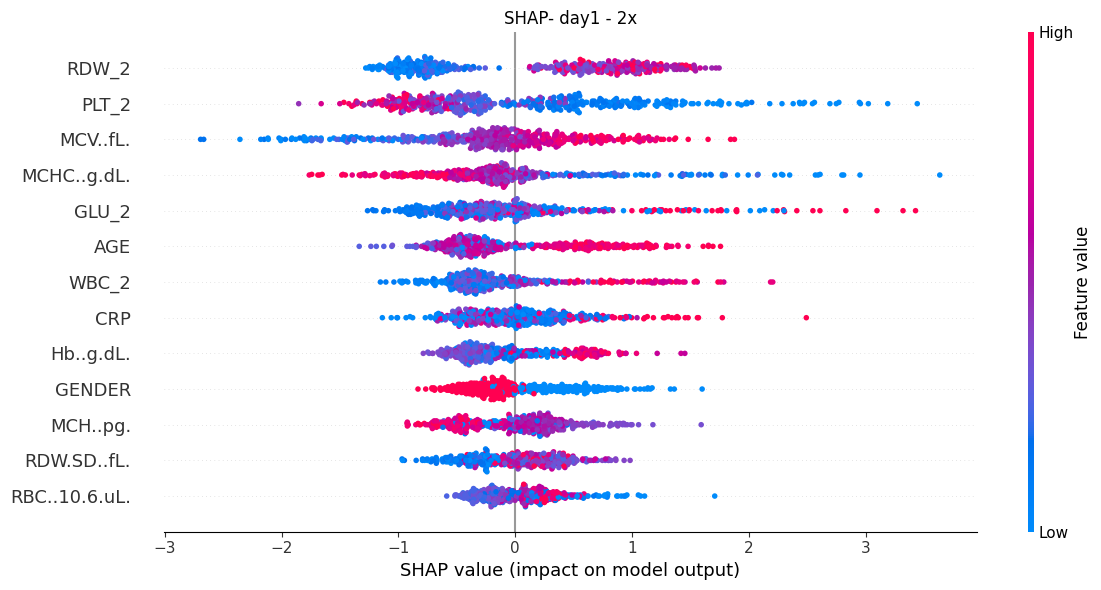

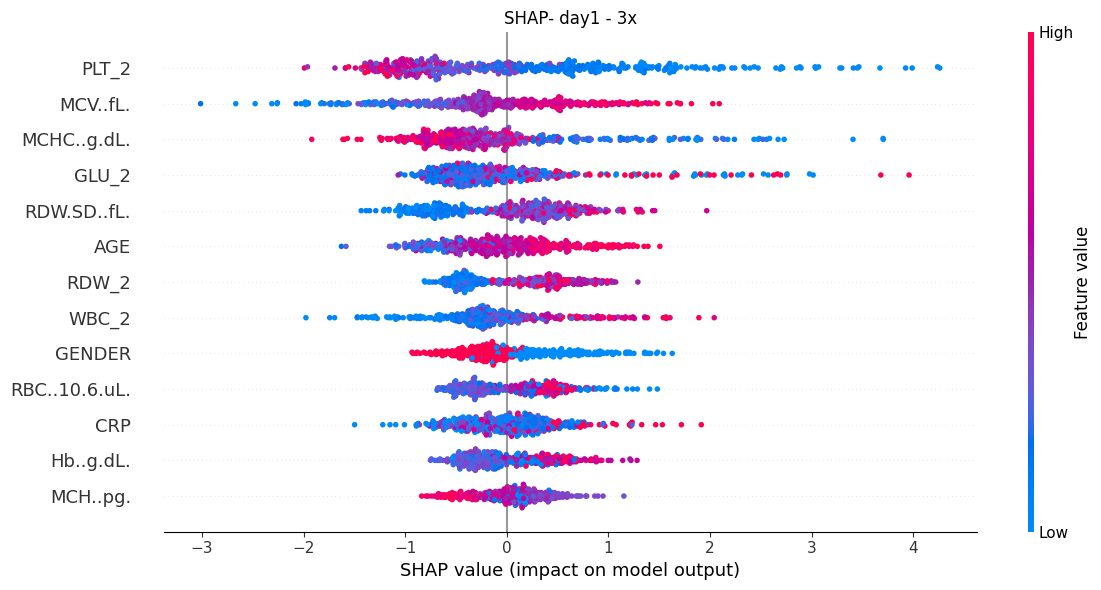


========== day3 - Base ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64

📊 day3 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6250 |
| Recall     | 0.1786 |
| F1-score   | 0.2778 |
| Accuracy   | 0.9443 |
| AUC        | 0.8470 |

========== day3 - 2x ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(326)}
SMOTE 後類別分布：
 death_within_3_days
0    4023
1     326
Name: count, dtype: int64

📊 day3 - 2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.7000 |
| Recall     | 0.2500 |
| F1-score   | 0.3684 |
| Accuracy   | 0.9486 |
| AUC        | 0.8249 |

========== day3 - 3x ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(489)}
SMOTE 後類別分布：
 death_within_3_days
0    4023
1     489
Name: count, dtype: int64

📊 day3 - 3x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6923 |

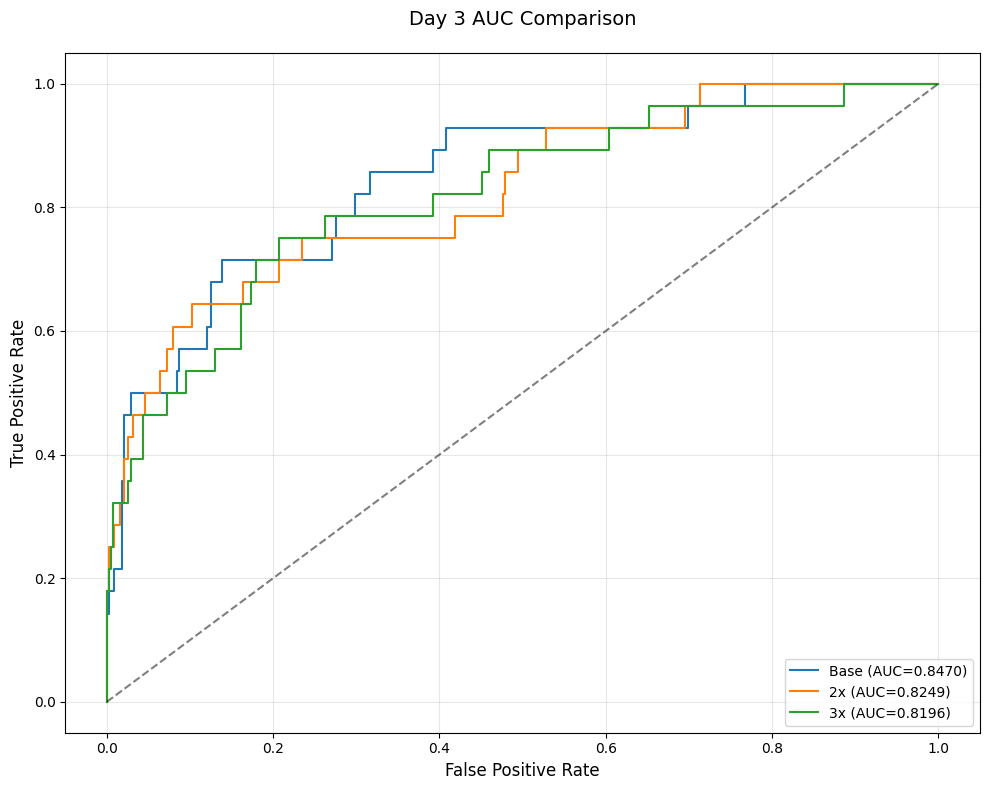

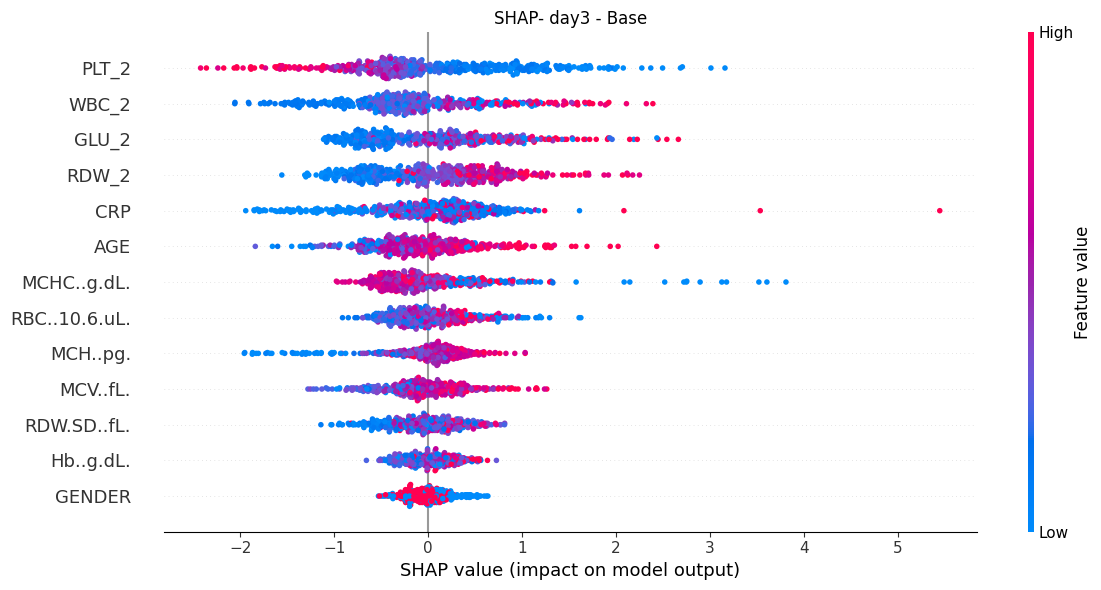

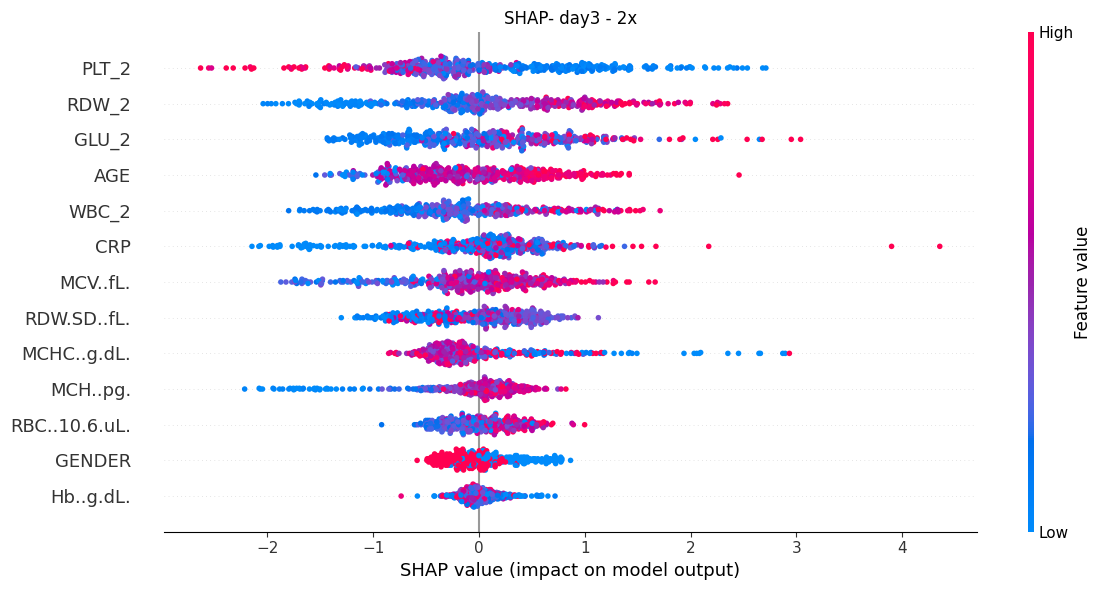

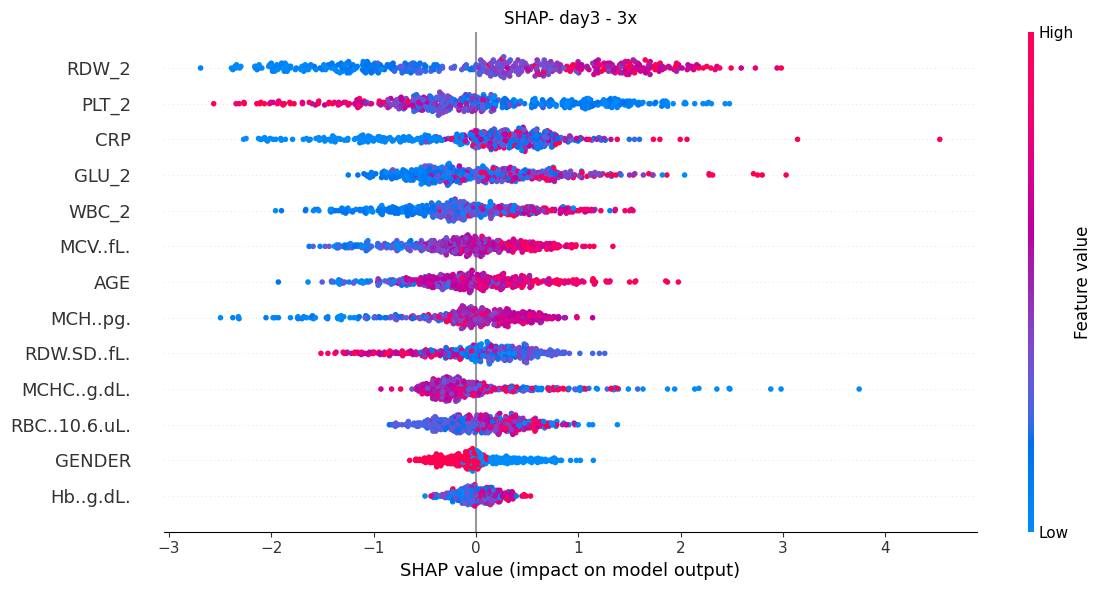


========== day5 - Base ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64

📊 day5 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6875 |
| Recall     | 0.2821 |
| F1-score   | 0.4000 |
| Accuracy   | 0.9293 |
| AUC        | 0.8977 |

========== day5 - 2x ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(524)}
SMOTE 後類別分布：
 death_within_5_days
0    3924
1     524
Name: count, dtype: int64

📊 day5 - 2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.5833 |
| Recall     | 0.3590 |
| F1-score   | 0.4444 |
| Accuracy   | 0.9251 |
| AUC        | 0.8705 |

========== day5 - 3x ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(786)}
SMOTE 後類別分布：
 death_within_5_days
0    3924
1     786
Name: count, dtype: int64

📊 day5 - 3x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6364 |

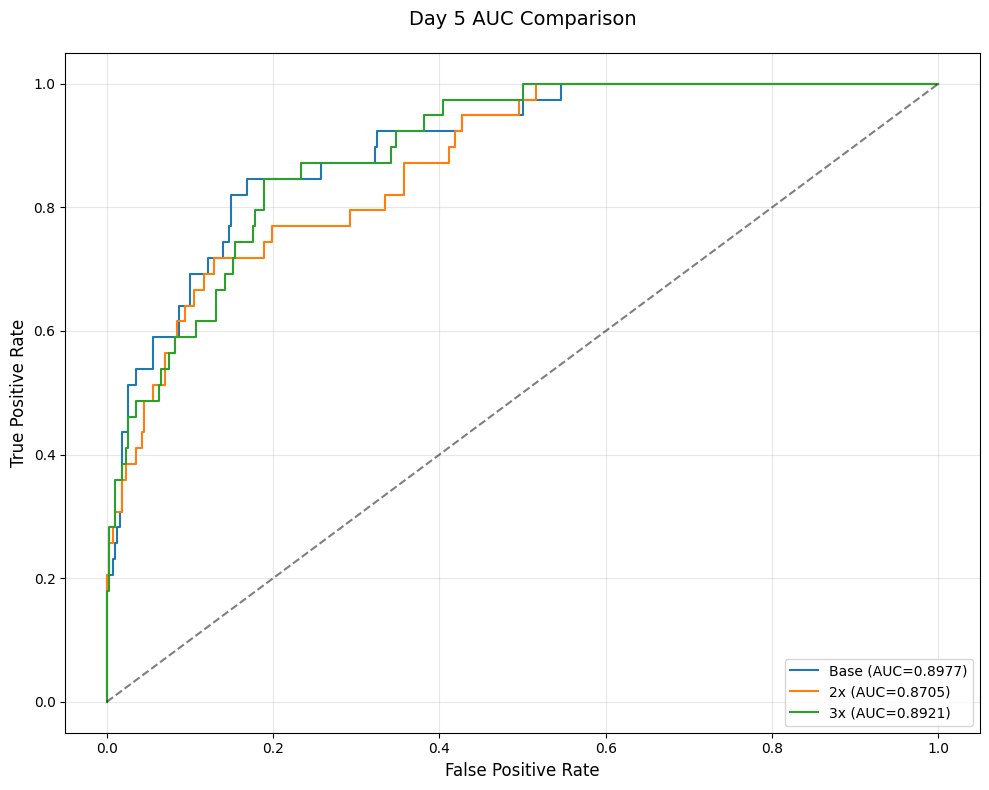

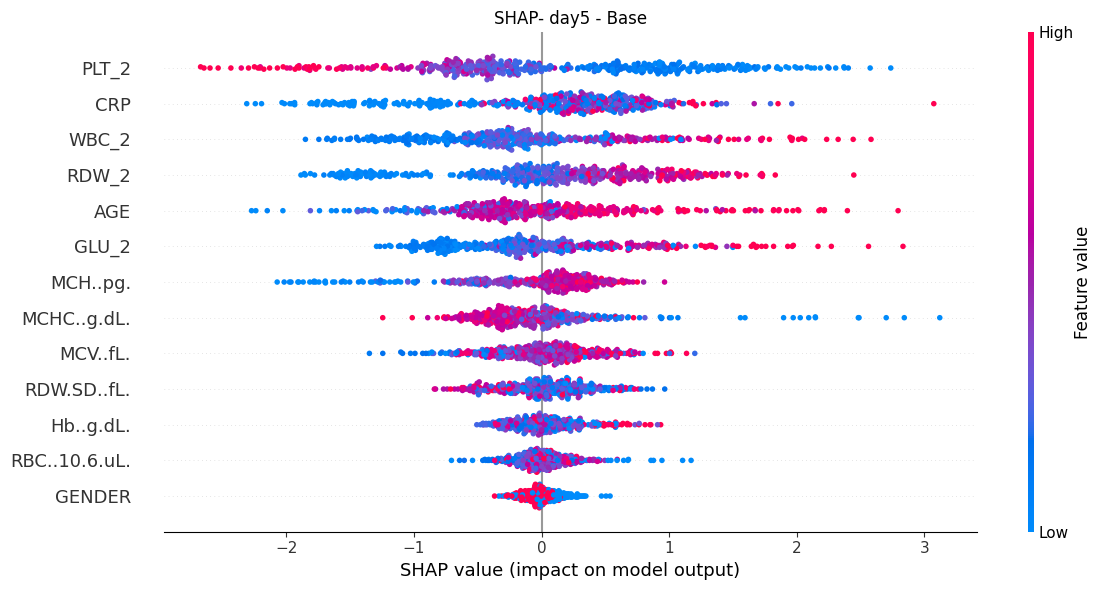

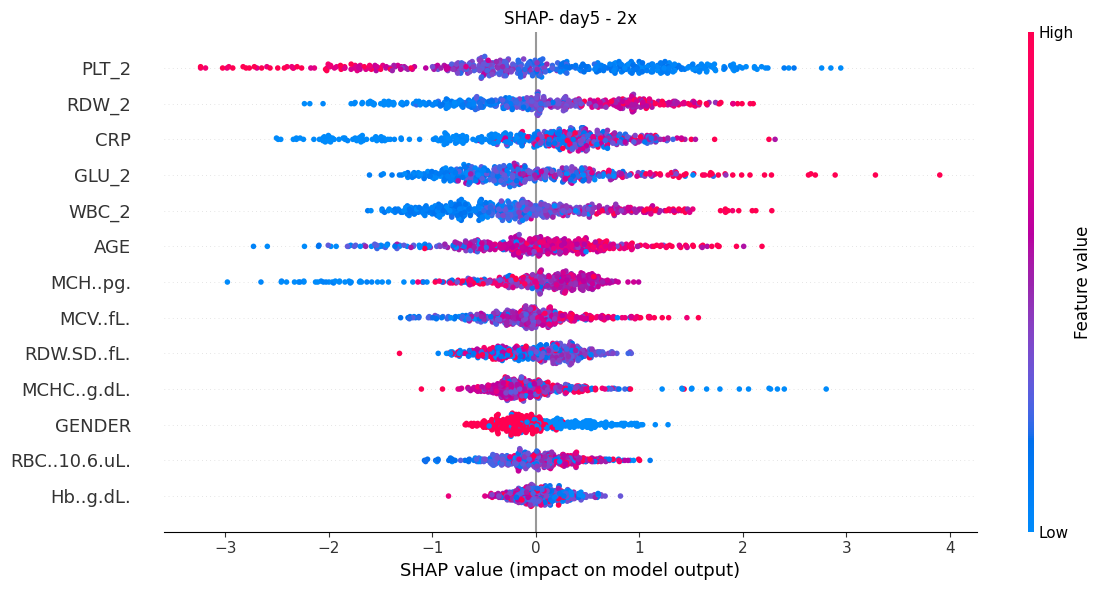

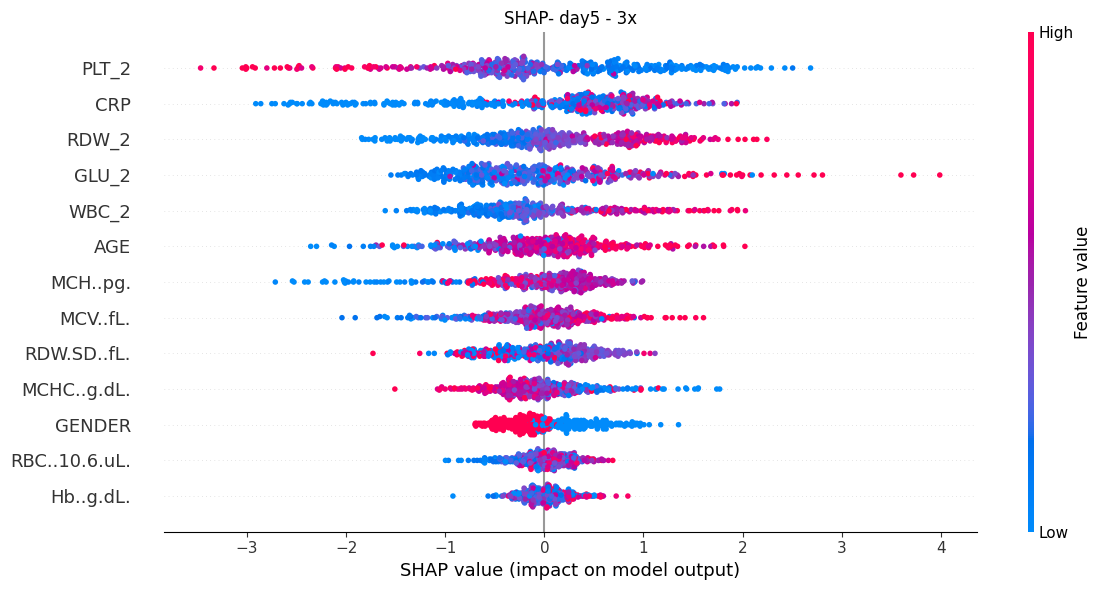

In [40]:
# ========== 修改训练函数 ==========
def train_and_evaluate_smote_strategy(X_train, X_test, y_train, y_test, feature_cols, title='', smote_strategy=None):
    print(f"\n========== {title} ==========")
    print("原始類別分布：\n", y_test.value_counts())

    X_train_use = X_train.copy()
    y_train_use = y_train.copy()

    if smote_strategy:
        print(f"📌 使用 SMOTE 策略：{smote_strategy}")
        smote = SMOTE(sampling_strategy=smote_strategy, random_state=42)
        X_train_use, y_train_use = smote.fit_resample(X_train_use[feature_cols], y_train_use)
        print("SMOTE 後類別分布：\n", pd.Series(y_train_use).value_counts())
    else:
        X_train_use = X_train_use[feature_cols]

    model = XGBClassifier(eval_metric='logloss', verbosity=0)
    model.fit(X_train_use, y_train_use)

    # 预测与评估
    y_pred = model.predict(X_test[feature_cols])
    y_proba = model.predict_proba(X_test[feature_cols])[:, 1]

    # 计算指标
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # 打印报表
    print(f"\n📊 {title} 評估結果:")
    print(f"| 指標       | 數值   |")
    print(f"|------------|--------|")
    print(f"| Precision  | {precision:.4f} |")
    print(f"| Recall     | {recall:.4f} |")
    print(f"| F1-score   | {f1:.4f} |")
    print(f"| Accuracy   | {accuracy:.4f} |")
    print(f"| AUC        | {auc:.4f} |")

    # 计算 ROC 曲线数据
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    # SHAP 分析
    explainer = shap.Explainer(model, X_test[feature_cols])
    shap_values = explainer(X_test[feature_cols])

    return {
        'model': model,
        'shap_values': shap_values,
        'features': feature_cols,
        'fpr': fpr,
        'tpr': tpr,
        'auc': auc,
        'metrics': (precision, recall, f1, accuracy)
    }

def plot_auc_comparison(day_data, day):
    plt.figure(figsize=(10, 8))
    for strategy, data in day_data.items():
        plt.plot(data['fpr'], data['tpr'],
                label=f'{strategy} (AUC={data["auc"]:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'Day {day} AUC Comparison', fontsize=14, pad=20)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/數位醫療/overleaf/day{day}_auc_comparison.png', dpi=300, bbox_inches='tight')  # 存成PNG檔
    plt.show()

def plot_shap_summary(shap_values, features, title, filename):
    plt.figure(figsize=(12, 6))
    shap.summary_plot(shap_values, features, show=False, plot_size=None)
    plt.title(f'SHAP- {title}', fontsize=12)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')  # 存成PNG檔
    plt.show()


# ========== 主流程修改 ==========
order = [(1, 'day1'), (3, 'day3'), (5, 'day5')]

for day_num, day_label in order:
    label = f'death_within_{day_num}_day' if day_num == 1 else f'death_within_{day_num}_days'

    # 初始化数据存储
    day_data = {}
    shap_data = []

    # 获取类别分布
    y_train = X_train[label]
    majority = y_train.value_counts()[0]
    minority = y_train.value_counts()[1]

    # SMOTE策略配置
    smote_configs = [
        ('Base', None),
        ('2x', {1: min(minority*2, majority)}),
        ('3x', {1: min(minority*3, majority)})
    ]

    # 过滤无效策略
    valid_configs = []
    for tag, strategy in smote_configs:
        if strategy and list(strategy.values())[0] < minority:
            print(f"⚠️ 跳过无效策略：{tag}")
            continue
        valid_configs.append((tag, strategy))

    # 执行各策略训练
    for tag, strategy in valid_configs:
        result = train_and_evaluate_smote_strategy(
            X_train,
            X_test,
            y_train,
            X_test[label],
            feature_cols,
            title=f'{day_label} - {tag}',
            smote_strategy=strategy
        )

        # 存储数据
        day_data[tag] = {
            'fpr': result['fpr'],
            'tpr': result['tpr'],
            'auc': result['auc']
        }

        # 存储SHAP数据
        shap_data.append({
            'values': result['shap_values'],
            'title': f'{day_label} - {tag}'
        })

    # 绘制AUC比较图
    plot_auc_comparison(day_data, day_num)

    # 绘制SHAP图
    for data in shap_data:
      tag = data['title']  # 這裡會是 'base', '2x', '3x'
      filename = f"/content/drive/MyDrive/Colab Notebooks/數位醫療/overleaf/{tag}_shap.png"
      plot_shap_summary(data['values'], X_test[feature_cols], f"{tag}", filename)



========== day1 - Base ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64

📊 day1 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.5000 |
| Recall     | 0.1111 |
| F1-score   | 0.1818 |
| Accuracy   | 0.9807 |
| AUC        | 0.8462 |
📌 day1 - Base：Top 3 特徵 => ['PLT_2', 'RDW_2', 'MCHC..g.dL.']

========== day1- top3 - Base ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64

📊 day1- top3 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.0000 |
| Recall     | 0.0000 |
| F1-score   | 0.0000 |
| Accuracy   | 0.9786 |
| AUC        | 0.8268 |

========== day1 - 2x ==========
原始類別分布：
 death_within_1_day
0    458
1      9
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(134)}
SMOTE 後類別分布：
 death_within_1_day
0    4119
1     134
Name: count, dtype: int64

📊 day1 - 2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.3333 |
| Recall     | 0.1111 |
| F1-score   | 0

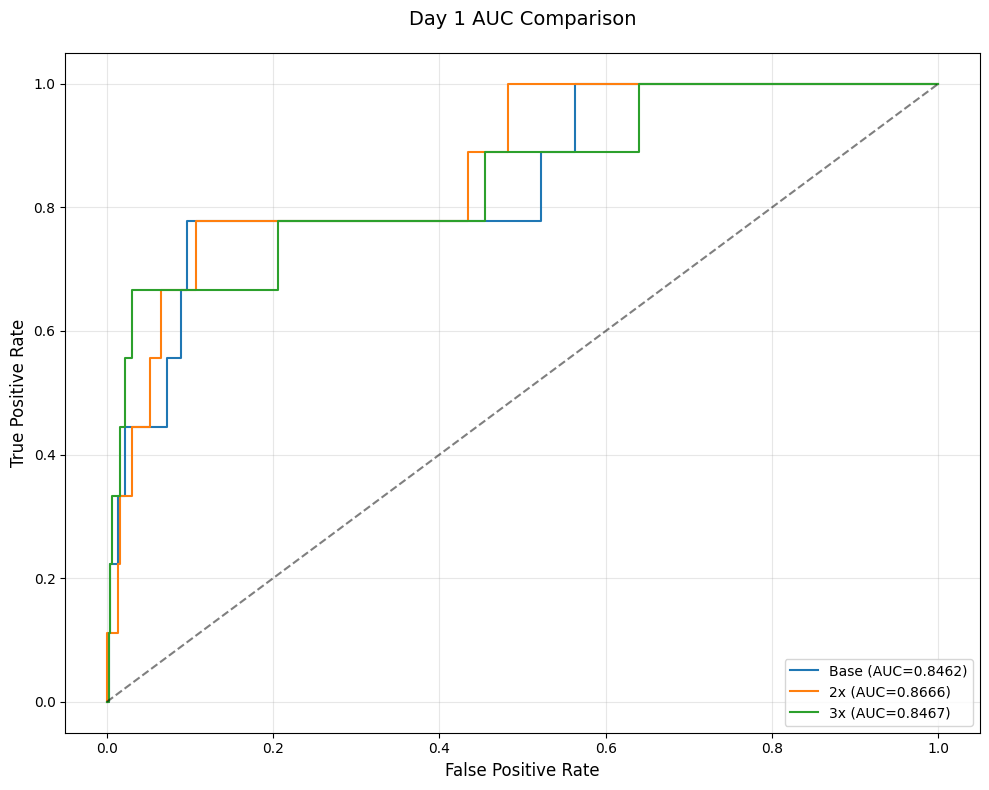

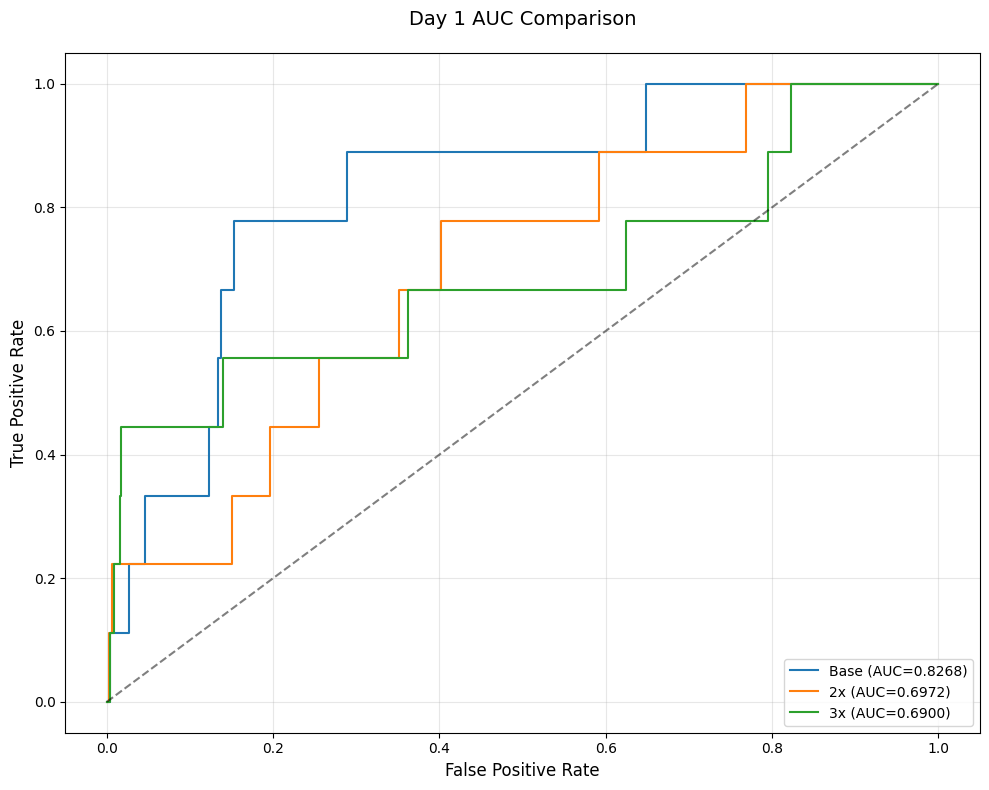


========== day3 - Base ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64

📊 day3 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6250 |
| Recall     | 0.1786 |
| F1-score   | 0.2778 |
| Accuracy   | 0.9443 |
| AUC        | 0.8470 |
📌 day3 - Base：Top 3 特徵 => ['PLT_2', 'WBC_2', 'GLU_2']

========== day3- top3 - Base ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64

📊 day3- top3 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 1.0000 |
| Recall     | 0.0357 |
| F1-score   | 0.0690 |
| Accuracy   | 0.9422 |
| AUC        | 0.7602 |

========== day3 - 2x ==========
原始類別分布：
 death_within_3_days
0    439
1     28
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(326)}
SMOTE 後類別分布：
 death_within_3_days
0    4023
1     326
Name: count, dtype: int64

📊 day3 - 2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.7000 |
| Recall     | 0.2500 |
| F1-score   | 0.3

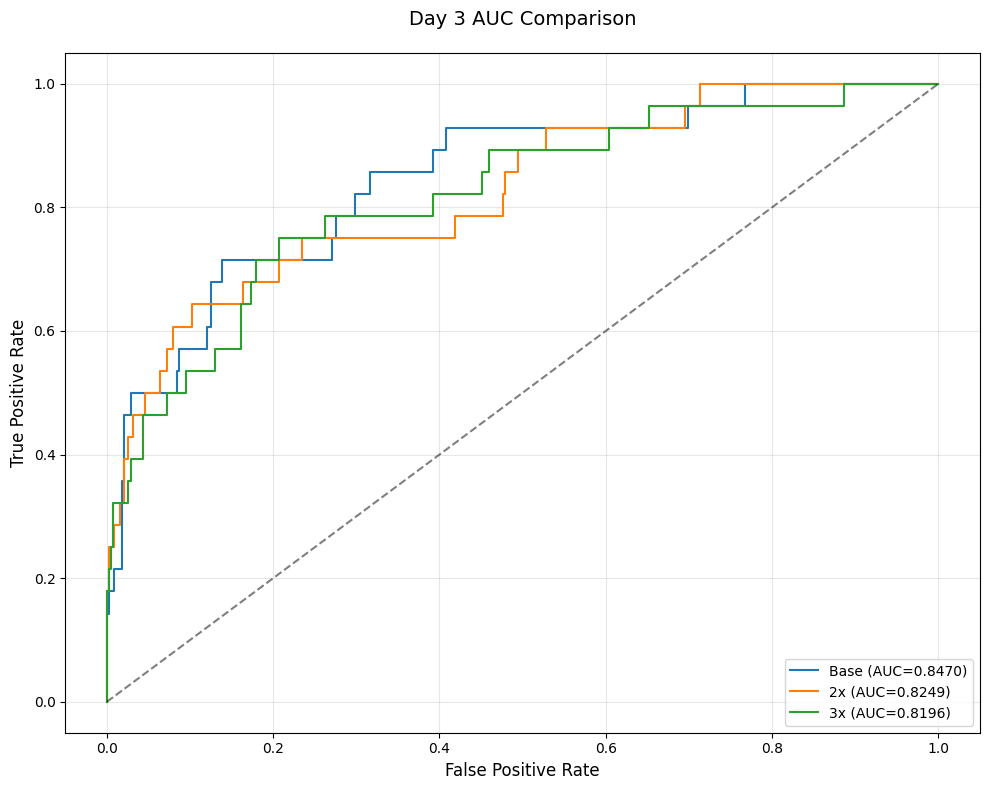

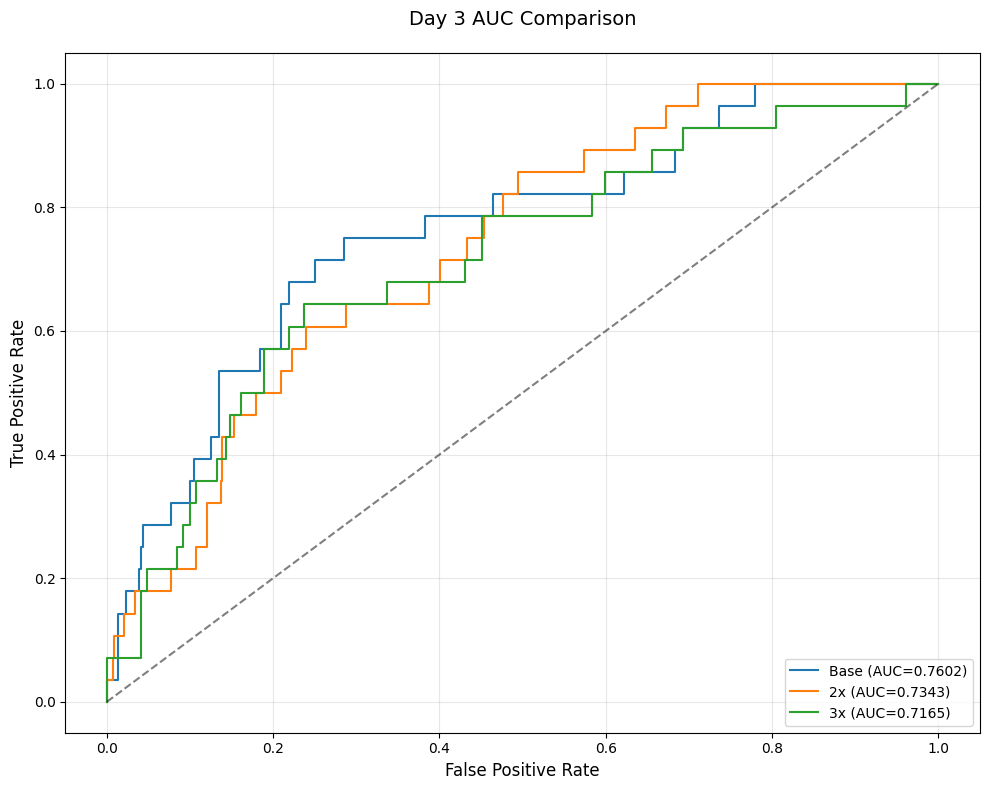


========== day5 - Base ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64

📊 day5 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.6875 |
| Recall     | 0.2821 |
| F1-score   | 0.4000 |
| Accuracy   | 0.9293 |
| AUC        | 0.8977 |
📌 day5 - Base：Top 3 特徵 => ['PLT_2', 'CRP', 'WBC_2']

========== day5- top3 - Base ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64

📊 day5- top3 - Base 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.7143 |
| Recall     | 0.1282 |
| F1-score   | 0.2174 |
| Accuracy   | 0.9229 |
| AUC        | 0.8021 |

========== day5 - 2x ==========
原始類別分布：
 death_within_5_days
0    428
1     39
Name: count, dtype: int64
📌 使用 SMOTE 策略：{1: np.int64(524)}
SMOTE 後類別分布：
 death_within_5_days
0    3924
1     524
Name: count, dtype: int64

📊 day5 - 2x 評估結果:
| 指標       | 數值   |
|------------|--------|
| Precision  | 0.5833 |
| Recall     | 0.3590 |
| F1-score   | 0.444

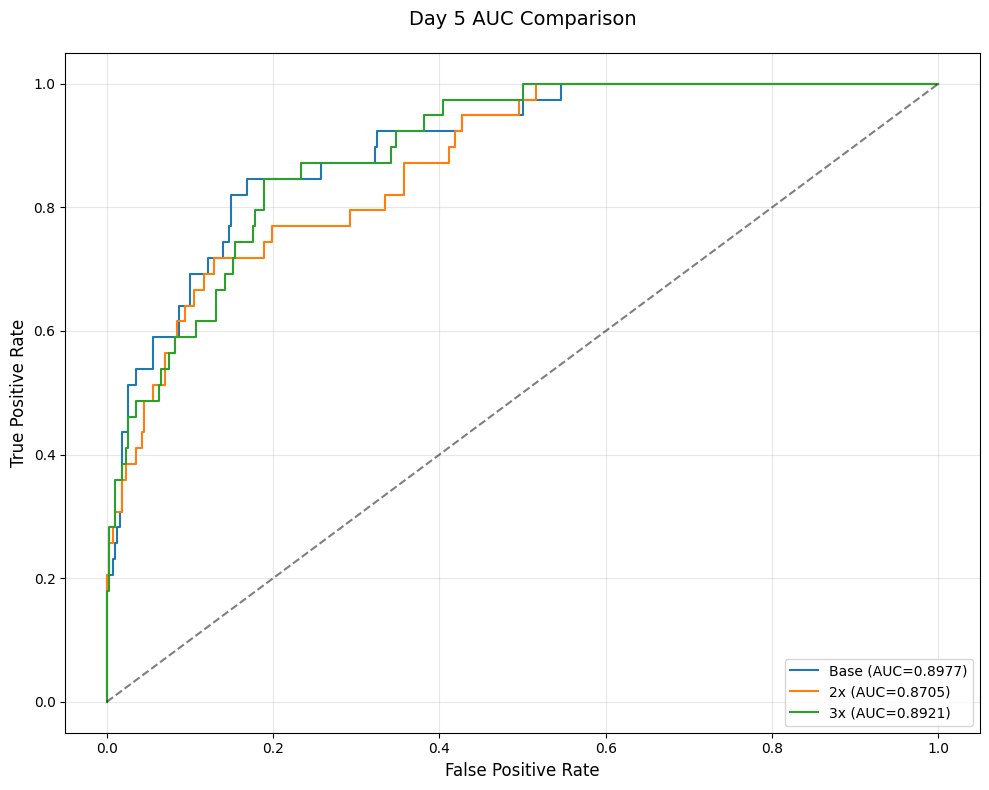

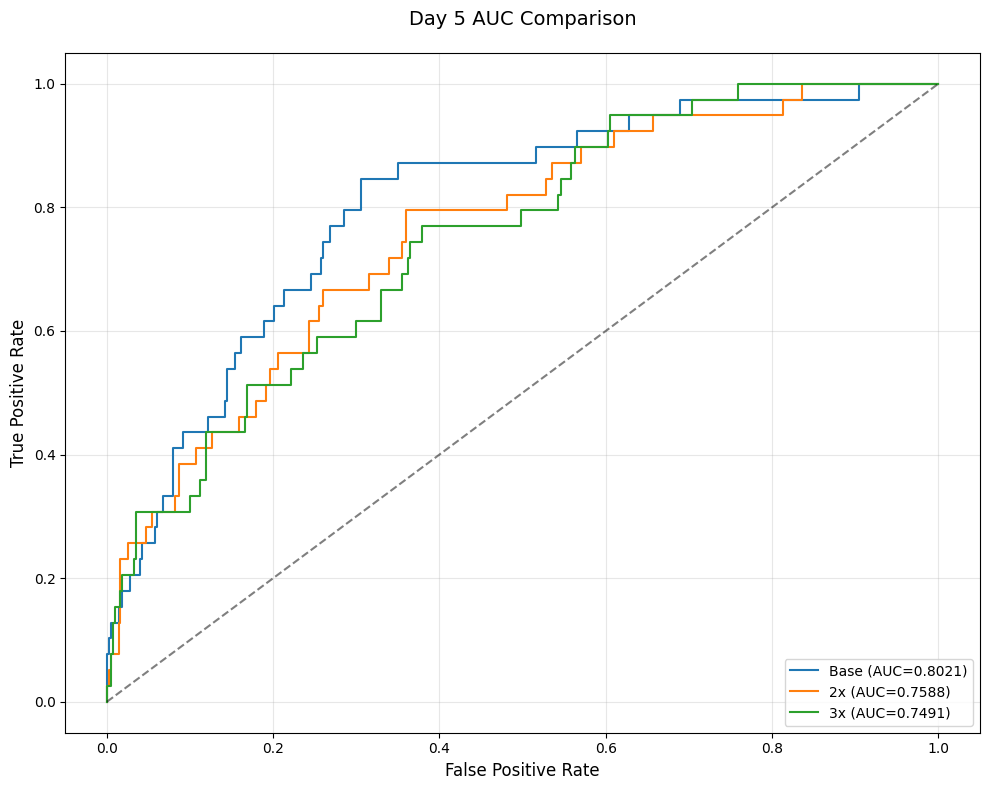

In [39]:
# ========== 主流程修改 ==========
order = [(1, 'day1'), (3, 'day3'), (5, 'day5')]

for day_num, day_label in order:
    label = f'death_within_{day_num}_day' if day_num == 1 else f'death_within_{day_num}_days'

    # 初始化数据存储
    day_data = {}
    day_data2 = {}  # 新增 day_data2 的初始化
    shap_data = []
    shap_data2 = []  # 新增 shap_data2 的初始化

    # 获取类别分布
    y_train = X_train[label]
    majority = y_train.value_counts()[0]
    minority = y_train.value_counts()[1]

    # SMOTE策略配置
    smote_configs = [
        ('Base', None),
        ('2x', {1: min(minority*2, majority)}),
        ('3x', {1: min(minority*3, majority)})
    ]

    # 过滤无效策略
    valid_configs = []
    for tag, strategy in smote_configs:
        if strategy and list(strategy.values())[0] < minority:
            print(f"⚠️ 跳过无效策略：{tag}")
            continue
        valid_configs.append((tag, strategy))

    # 执行各策略训练
    for tag, strategy in valid_configs:
        result = train_and_evaluate_smote_strategy(
            X_train,
            X_test,
            y_train,
            X_test[label],
            feature_cols,
            title=f'{day_label} - {tag}',
            smote_strategy=strategy
        )

        # 修正1: 提取 SHAP 值的 values 属性
        shap_mean = np.abs(result['shap_values'].values).mean(axis=0)
        top3_idx = np.argsort(shap_mean)[-3:][::-1]

        # 修正2: 使用 feature_cols 而非未定义的 used_features
        top3_feats = [feature_cols[i] for i in top3_idx]
        print(f"📌 {day_label} - {tag}：Top 3 特徵 => {top3_feats}")

        # 使用 top3 特徵重新訓練
        result2 = train_and_evaluate_smote_strategy(
            X_train,
            X_test,
            y_train,
            X_test[label],
            top3_feats,
            title=f'{day_label}- top3 - {tag}',
            smote_strategy=strategy
        )

        # 存储数据
        day_data[tag] = {
            'fpr': result['fpr'],
            'tpr': result['tpr'],
            'auc': result['auc']
        }

        day_data2[tag] = {  # 修正 day_data2 的定義
            'fpr': result2['fpr'],
            'tpr': result2['tpr'],
            'auc': result2['auc']
        }

        # 存储SHAP数据
        shap_data.append({
            'values': result['shap_values'],
            'title': f'{day_label} - {tag}'
        })

        shap_data2.append({  # 修正 shap_data2 的定義
            'values': result2['shap_values'],
            'title': f'{day_label} top3- {tag}'
        })

    # 繪圖部分需確保 day_num2 存在或使用正確變數
    plot_auc_comparison(day_data, day_num)   # 原始特徵的 AUC
    plot_auc_comparison(day_data2, day_num)  # top3 特徵的 AUC (day_num2 應改為 day_num)
